In [22]:
#def shallow_roe_1D(q_l, q_r, aux_l, aux_r, problem_data):
def shallow_roe_1D(g, h_face, q_face): #q_l, q_r, aux_l, aux_r, problem_data):    
    r"""
    Roe shallow water solver in 1d::
        ubar = (sqrt(u_l) + sqrt(u_r)) / (sqrt(h_l) + sqrt(h_r))
        cbar = sqrt( 0.5 * g * (h_l + h_r))
        W_1 = |      1      |  s_1 = ubar - cbar
              | ubar - cbar |
        W_2 = |      1      |  s_1 = ubar + cbar
              | ubar + cbar |
        a1 = 0.5 * ( - delta_hu + (ubar + cbar) * delta_h ) / cbar
        a2 = 0.5 * (   delta_hu - (ubar - cbar) * delta_h ) / cbar
    *problem_data* should contain:
     - *g* - (float) Gravitational constant
     - *efix* - (bool) Boolean as to whether a entropy fix should be used, if
       not present, false is assumed
    :Version: 1.0 (2009-02-05)
    """
    aux_l = h_face.L
    aux_r = h_face.R
    q_l = q_face.L
    q_r = q_face.R
    problem_data = {
        'grav': g,
        'efix': False
    }
    #u_L = q_L/h_L
    #u_R = q_R/h_R

    
    # Array shapes
    num_rp = q_l.shape[1]

    # Output arrays
    wave = np.empty( (num_eqn, num_waves, num_rp) )
    s = np.zeros( (num_waves, num_rp) )
    amdq = np.zeros( (num_eqn, num_rp) )
    apdq = np.zeros( (num_eqn, num_rp) )

    # Compute roe-averaged quantities
    ubar = ( (q_l[1,:]/np.sqrt(q_l[0,:]) + q_r[1,:]/np.sqrt(q_r[0,:])) /
             (np.sqrt(q_l[0,:]) + np.sqrt(q_r[0,:])) )
    cbar = np.sqrt(0.5 * problem_data['grav'] * (q_l[0,:] + q_r[0,:]))

    # Compute Flux structure
    delta = q_r - q_l
    a1 = 0.5 * (-delta[1,:] + (ubar + cbar) * delta[0,:]) / cbar
    a2 = 0.5 * ( delta[1,:] - (ubar - cbar) * delta[0,:]) / cbar

    # Compute each family of waves
    wave[0,0,:] = a1
    wave[1,0,:] = a1 * (ubar - cbar)
    s[0,:] = ubar - cbar

    wave[0,1,:] = a2
    wave[1,1,:] = a2 * (ubar + cbar)
    s[1,:] = ubar + cbar

    if problem_data['efix']:
        raise NotImplementedError("Entropy fix has not been implemented.")
    else:
        s_index = np.zeros((2,num_rp))
        for m in range(num_eqn):
            for mw in range(num_waves):
                s_index[0,:] = s[mw,:]
                amdq[m,:] += np.min(s_index,axis=0) * wave[m,mw,:]
                apdq[m,:] += np.max(s_index,axis=0) * wave[m,mw,:]

    return wave, s, amdq, apdq

In [23]:
import math

#print 'This is a 1D python program for solving 1D shallow water equations with fvm'
#print 'author: xilin xia'
#print 'date: 21/10/2014'

#global arrays
h = [1.0]*100+[0.1]*100
q = [0]*200
zbf = [0]*200
dhdt = [0]*200
dqdt = [0]*200
h_old = [0]*200
q_old = [0]*200
dhdt_old = [0]*200
dqdt_old = [0]*200

#total cell number
N = 200

#parameters
g = 9.81
x_ori = 0.0
dx = 0.05

#time controll
t = 0.0
dt = 0.001
tout = 6


class RiemannState:
    def __init__(self, L = 0.0, R = 0.0):
        self.L = L
        self.R = R

class Flux:
    def __init__(self, h = 0.0, q = 0.0):
        self.h = h
        self.q = q

#hllc riemann solver
def hllc(g, h_face, q_face):
    h_L = h_face.L
    h_R = h_face.R
    q_L = q_face.L
    q_R = q_face.R
    u_L = q_L/h_L
    u_R = q_R/h_R
    h_star_p = (math.sqrt(g*h_L) + math.sqrt(g*h_R)) / 2 + (u_L - u_R) / 4
    u_star = (u_L + u_R) / 2 + math.sqrt(g*h_L) - math.sqrt(g*h_R)
    h_star = (h_star_p*h_star_p) / g

    s_L = min(u_L - math.sqrt(g*h_L), u_star - math.sqrt(g*h_star))
    s_R = max(u_R + math.sqrt(g*h_R), u_star + math.sqrt(g*h_star))
 
    h_flux_L = q_L
    h_flux_R = q_R
    h_flux_star = (s_R*h_flux_L - s_L*h_flux_R + s_L*s_R*(h_R - h_L)) / (s_R - s_L)
    q_flux_L = q_L*u_L + g*h_L*h_L / 2.0
    q_flux_R = q_R*u_R + g*h_R*h_R / 2.0
    q_flux_star = (s_R*q_flux_L - s_L*q_flux_R + s_L*s_R*(q_R - q_L)) / (s_R - s_L)
 
    if 0 <= s_L:
        h_flux = h_flux_L
        q_flux = q_flux_L
    elif  s_L <= 0 and 0 <= s_R:
        h_flux = h_flux_star
        q_flux = q_flux_star
    else:
        h_flux = h_flux_R
        q_flux = q_flux_R

    return Flux(h_flux, q_flux)

#function to calculate dhdt and dqdt
def calcDDt(h,q,dhdt,dqdt,dx):
    N = len(q)
    for i in range(N):
        #west face
        if i == 0:
            h_west = RiemannState(h[i],h[i])
            q_west = RiemannState(q[i],q[i])
        else:
            h_west = RiemannState(h[i-1],h[i])
            q_west = RiemannState(q[i-1],q[i])
        flux_west = shallow_roe_1D(g, h_west, q_west)    

        #east face
        if i == N - 1:
            h_east = RiemannState(h[i],h[i])
            q_east = RiemannState(q[i],q[i])
        else:
            h_east = RiemannState(h[i],h[i+1])
            q_east = RiemannState(q[i],q[i+1])
        flux_east = shallow_roe_1D(g, h_east, q_east)

        dhdt[i] = - (flux_east.h - flux_west.h)/dx
        dqdt[i] = - (flux_east.q - flux_west.q)/dx


#main function
while t < tout:
    #print(dt, t)
    #first Runge-Kutta
    calcDDt(h,q,dhdt,dqdt,dx)
    h_old = h[:]
    q_old = q[:]
    dhdt_old = dhdt[:]
    dqdt_old = dqdt[:]
    for i in range(N):
        h[i] = h[i] + dhdt[i]*dt
        q[i] = q[i] + dqdt[i]*dt
    #second Runge-Kutta
    calcDDt(h,q,dhdt,dqdt,dx)
    for i in range(N):
        h[i] = h_old[i] + (dhdt[i] + dhdt_old[i])*dt/2.0
        q[i] = q_old[i] + (dqdt[i] + dqdt_old[i])*dt/2.0

    t = t + dt

#output

#f = open('output.txt', 'w')

#for i in range(N):
#    print >> f, '%.6f %.6f %.6f' % (x_ori + i*dx, h[i], q[i])
#    print(x_ori + i*dx, h[i], q[i])
#f.close()

AttributeError: 'int' object has no attribute 'shape'

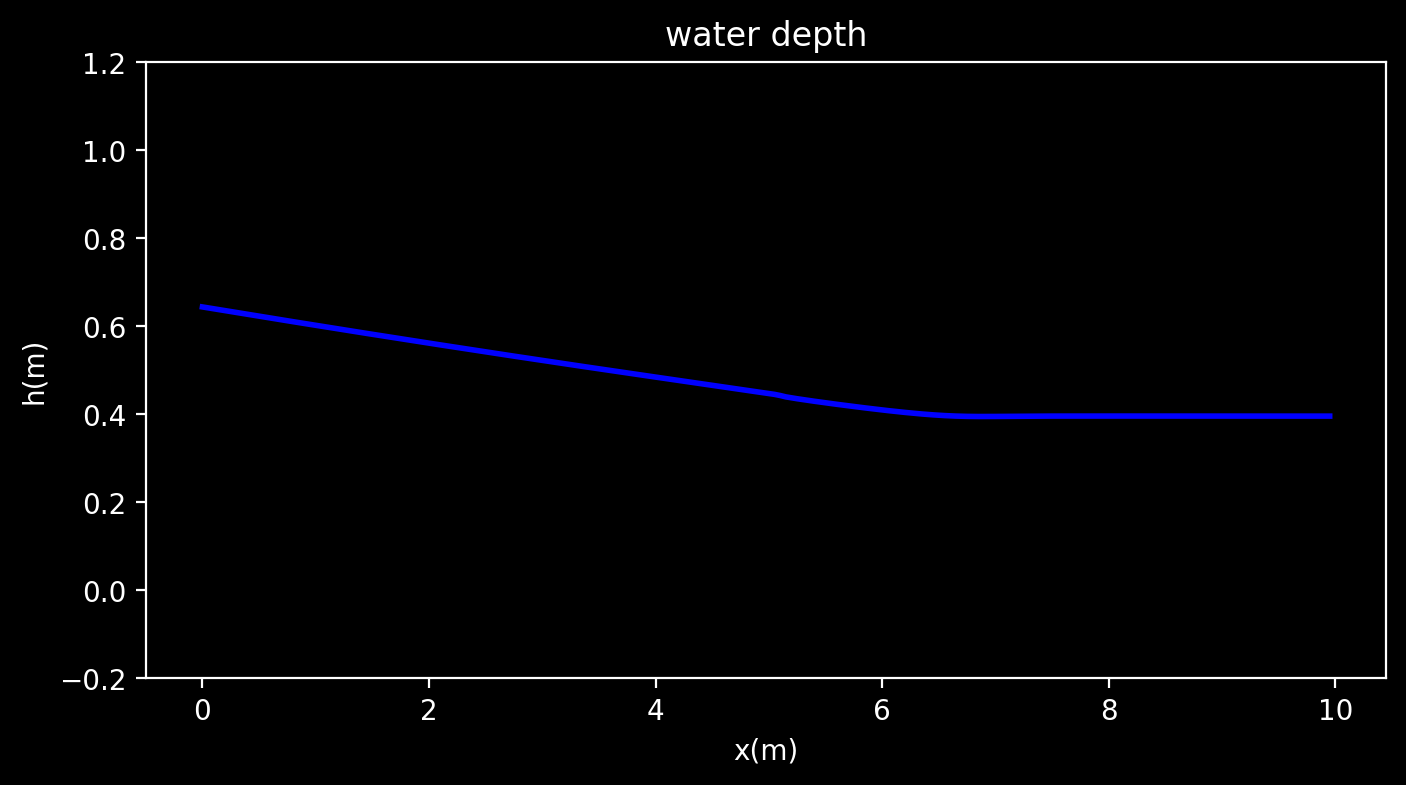

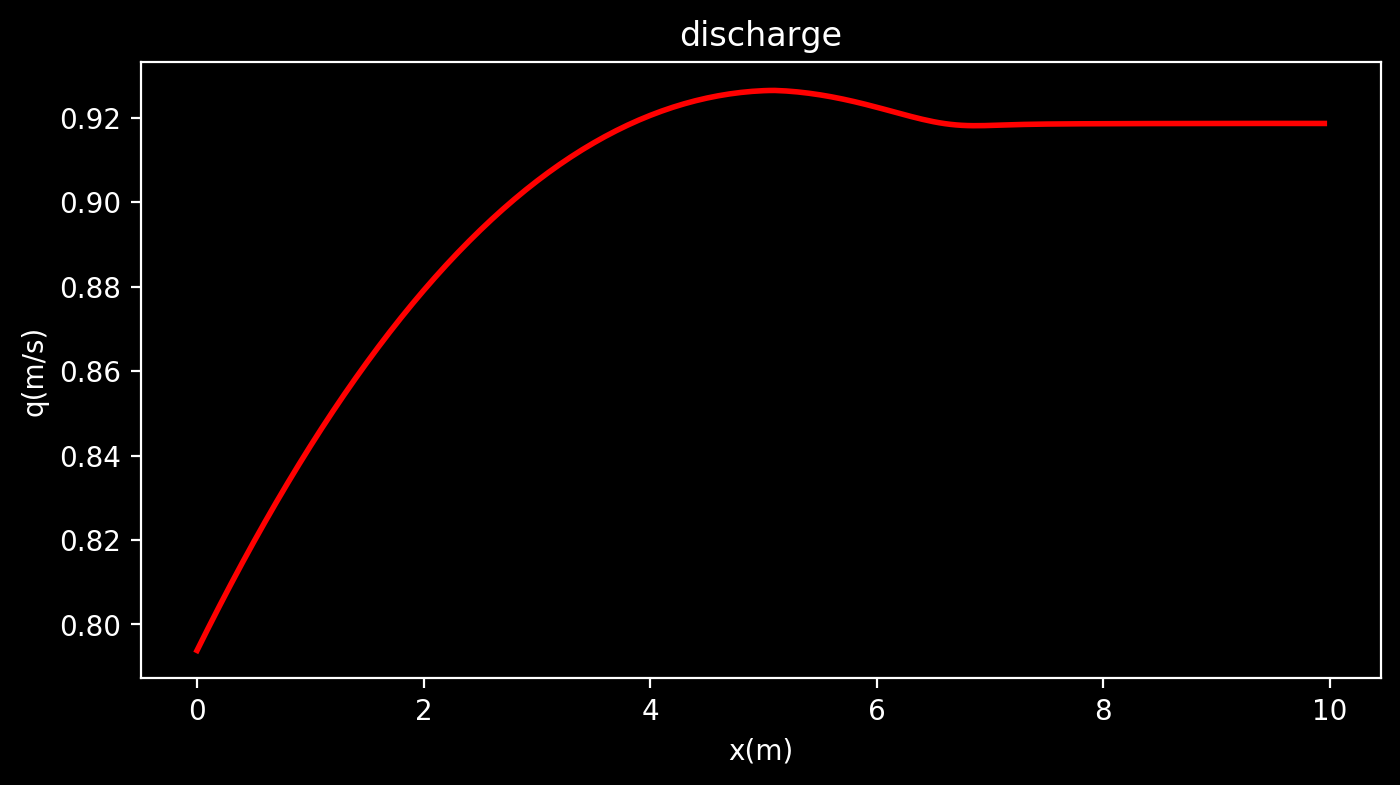

In [16]:
import matplotlib.pyplot as plt
import numpy as np

#data = np.loadtxt('output.txt')

x = np.zeros(200)
for i in range(N):
    x[i] = x_ori + i*dx
    
#h = data[:,1]
#q = data[:,2]

plt.figure(figsize=(8,4))
plt.plot(x,h,color='blue',linewidth=2)
plt.xlabel('x(m)')
plt.ylabel('h(m)')
plt.title('water depth')
plt.ylim(-0.2,1.2)
plt.show()


plt.figure(figsize=(8,4))
plt.plot(x,q,color='red',linewidth=2)
plt.xlabel('x(m)')
plt.ylabel('q(m/s)')
plt.title('discharge')
#plt.ylim(-0.2,1.2)
plt.show()